In [ ]:
# These are folders where we store our data

# Load packages
import os
import pandas as pd
import numpy as np
import glob
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

print(f"Running on PyMC v{pm.__version__}")


# Prepare data
curfolder = os.getcwd()
parentfolder = os.path.abspath(os.path.join(curfolder, os.pardir))

datafolder = os.path.join(parentfolder, 'datasets')
plotfolder = os.path.join(parentfolder, 'plots')


simfolder = os.path.join(datafolder, 'simulation_results')
simulations = glob.glob(os.path.join(simfolder, '*.npy'))

In [6]:
sim = simulations[0]

# Load in sim
sample = np.load(sim, allow_pickle=True)

In [16]:
sample[0][0][1]

[0.103267099501749,
 0.168881794806925,
 0.0009838969300215,
 0.207434297280964,
 0.0057212873064982,
 0.598383517234936,
 0.278145771546757,
 0.116191903009977,
 0.230481574460578,
 0.048071655752605,
 0.0,
 0.472059133573508,
 0.0034851400783534,
 0.0342276770581901,
 0.0998042788562661,
 0.426333098281685,
 0.0133785067643628,
 0.277312591741274,
 0.0944394879382488,
 0.371160404821761]

following pipeline is adapted from here: https://www.pymc.io/projects/examples/en/latest/case_studies/BEST.html

In [74]:
sample

array([[['laag (ruimtelijk)',
         list([0.103267099501749, 0.168881794806925, 0.0009838969300215, 0.207434297280964, 0.0057212873064982, 0.598383517234936, 0.278145771546757, 0.116191903009977, 0.230481574460578, 0.048071655752605, 0.0, 0.472059133573508, 0.0034851400783534, 0.0342276770581901, 0.0998042788562661, 0.426333098281685, 0.0133785067643628, 0.277312591741274, 0.0944394879382488, 0.371160404821761]),
         list([0.821798911682321, 0.58708527033899, 0.806693664743197, 0.931743098360341, 0.881240714739837, 0.311811018737983, 0.742166162664437, 0.833371693007839, 0.408518073664009, 0.999712475129802, 0.340210468044729, 0.628477565104349, 0.753992990622476, 0.745909008303607, 0.649445934435178, 0.705507723407255, 0.713311159531216, 0.985652698044476, 0.412655525969291, 0.552614726703322])],
        ['huid',
         list([0.497675041740218, 0.553242617064776, 0.375285180342234, 0.0243056964486989, 0.249933827315378, 0.103986980793746, 0.342246988117847, 0.383160093951479

In [11]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(seed=42)

In [17]:
for i in range(len(sample)):
    # This is the simulated expressibility
    express_array = np.array(sample[i])
    vocal = np.sum(express_array[:, 1])
    gesture = np.sum(express_array[:, 2])

In [73]:
express_array

array([['lever',
        list([0.252750764288533, 0.0006365132220188, 0.264781634077416, 0.110412300959269, 0.182296702859143, 0.0970494963683802, 0.0128869986716229, 0.0123899658581233, 0.0892546836096361, 0.0204540695188442, 0.109269156327378, 0.13122804799473, 0.150125920687457, 0.0051678078372841, 0.0273715173626117, 0.152254797284274, 0.140760098672944, 0.186523687808772, 0.0018591824798117, 0.0825587766990825]),
        list([0.255387509763635, 0.44378109976846, 0.534719682005158, 0.311207466736794, 0.0660564005377921, 0.256537220270765, 0.19267191845073, 1.0, 0.306021461264945, 0.253426898034718, 0.442956896231161, 0.297268891749231, 0.2962042530879, 0.44378109976846, 0.483085898269316, 0.827467774858144, 0.026643934775154, 0.370819632176718, 0.236251354934861, 0.0053472808225321])],
       ['drinken',
        list([0.691297268750293, 0.580528558360912, 0.681657193449114, 0.364131094233975, 0.320811193529946, 0.731940311591706, 0.934611143986321, 0.605432101843094, 0.66785715957

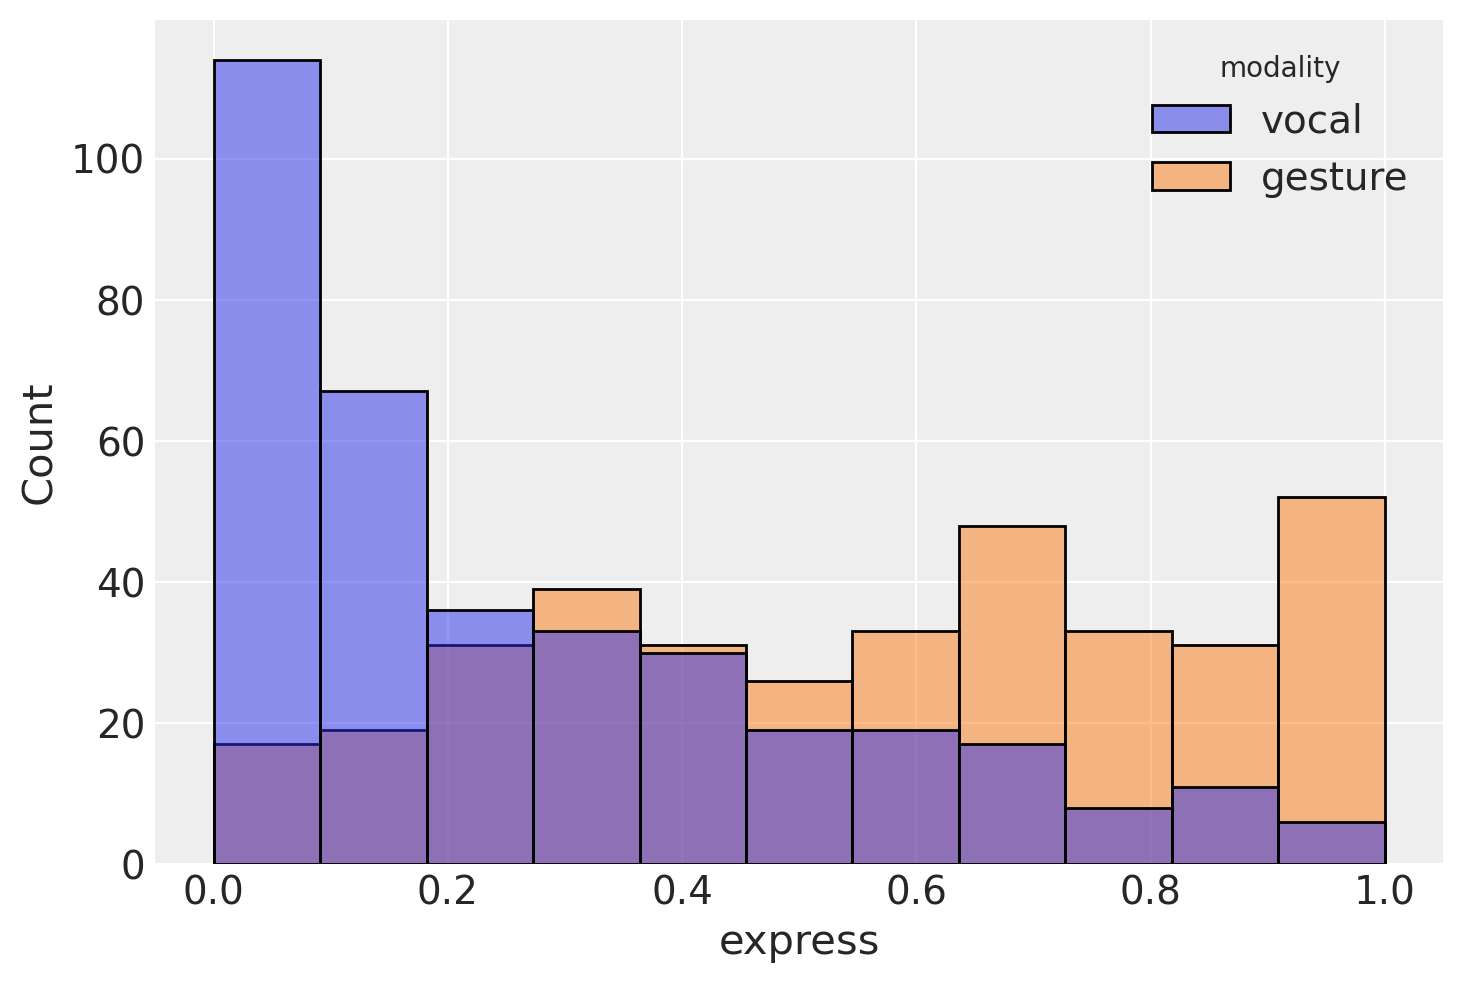

In [19]:
df1 = pd.DataFrame({"express": vocal, "modality": "vocal"})
df2 = pd.DataFrame({"express": gesture, "modality": "gesture"})
df_comp = pd.concat([df1, df2]).reset_index()

sns.histplot(data=df_comp, x="express", hue="modality");

In [65]:
import pymc as pm
import numpy as np
import arviz as az

# Combine data
data = np.concatenate([vocal, gesture])
group = np.array([0] * len(vocal) + [1] * len(gesture))  # 0 = vocal, 1 = gesture

with pm.Model() as best_model:
    mu_vocal = pm.Normal("mu_vocal", mu=0, sigma=10)
    mu_gesture = pm.Normal("mu_gesture", mu=0, sigma=10)

    sigma_vocal = pm.HalfNormal("sigma_vocal", sigma=10)
    sigma_gesture = pm.HalfNormal("sigma_gesture", sigma=10)

    nu = pm.Exponential("nu", 1/30)

    mu = pm.math.switch(group, mu_gesture, mu_vocal)
    sigma = pm.math.switch(group, sigma_gesture, sigma_vocal)

    obs = pm.StudentT("obs", nu=nu, mu=mu, sigma=sigma, observed=data)

    # Derived variable: difference in means
    mu_diff = pm.Deterministic("mu_diff", mu_gesture - mu_vocal)

    trace = pm.sample(2000, tune=1000, return_inferencedata=True)



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 18 seconds.


In [66]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [67]:
post_samples = trace.posterior['mu_diff'].values.flatten()
p_gt_0 = np.mean(post_samples > 0)#

print(f"Probability that gesture is greater than vocal: {p_gt_0:.3f}")

Probability that gesture is greater than vocal: 1.000


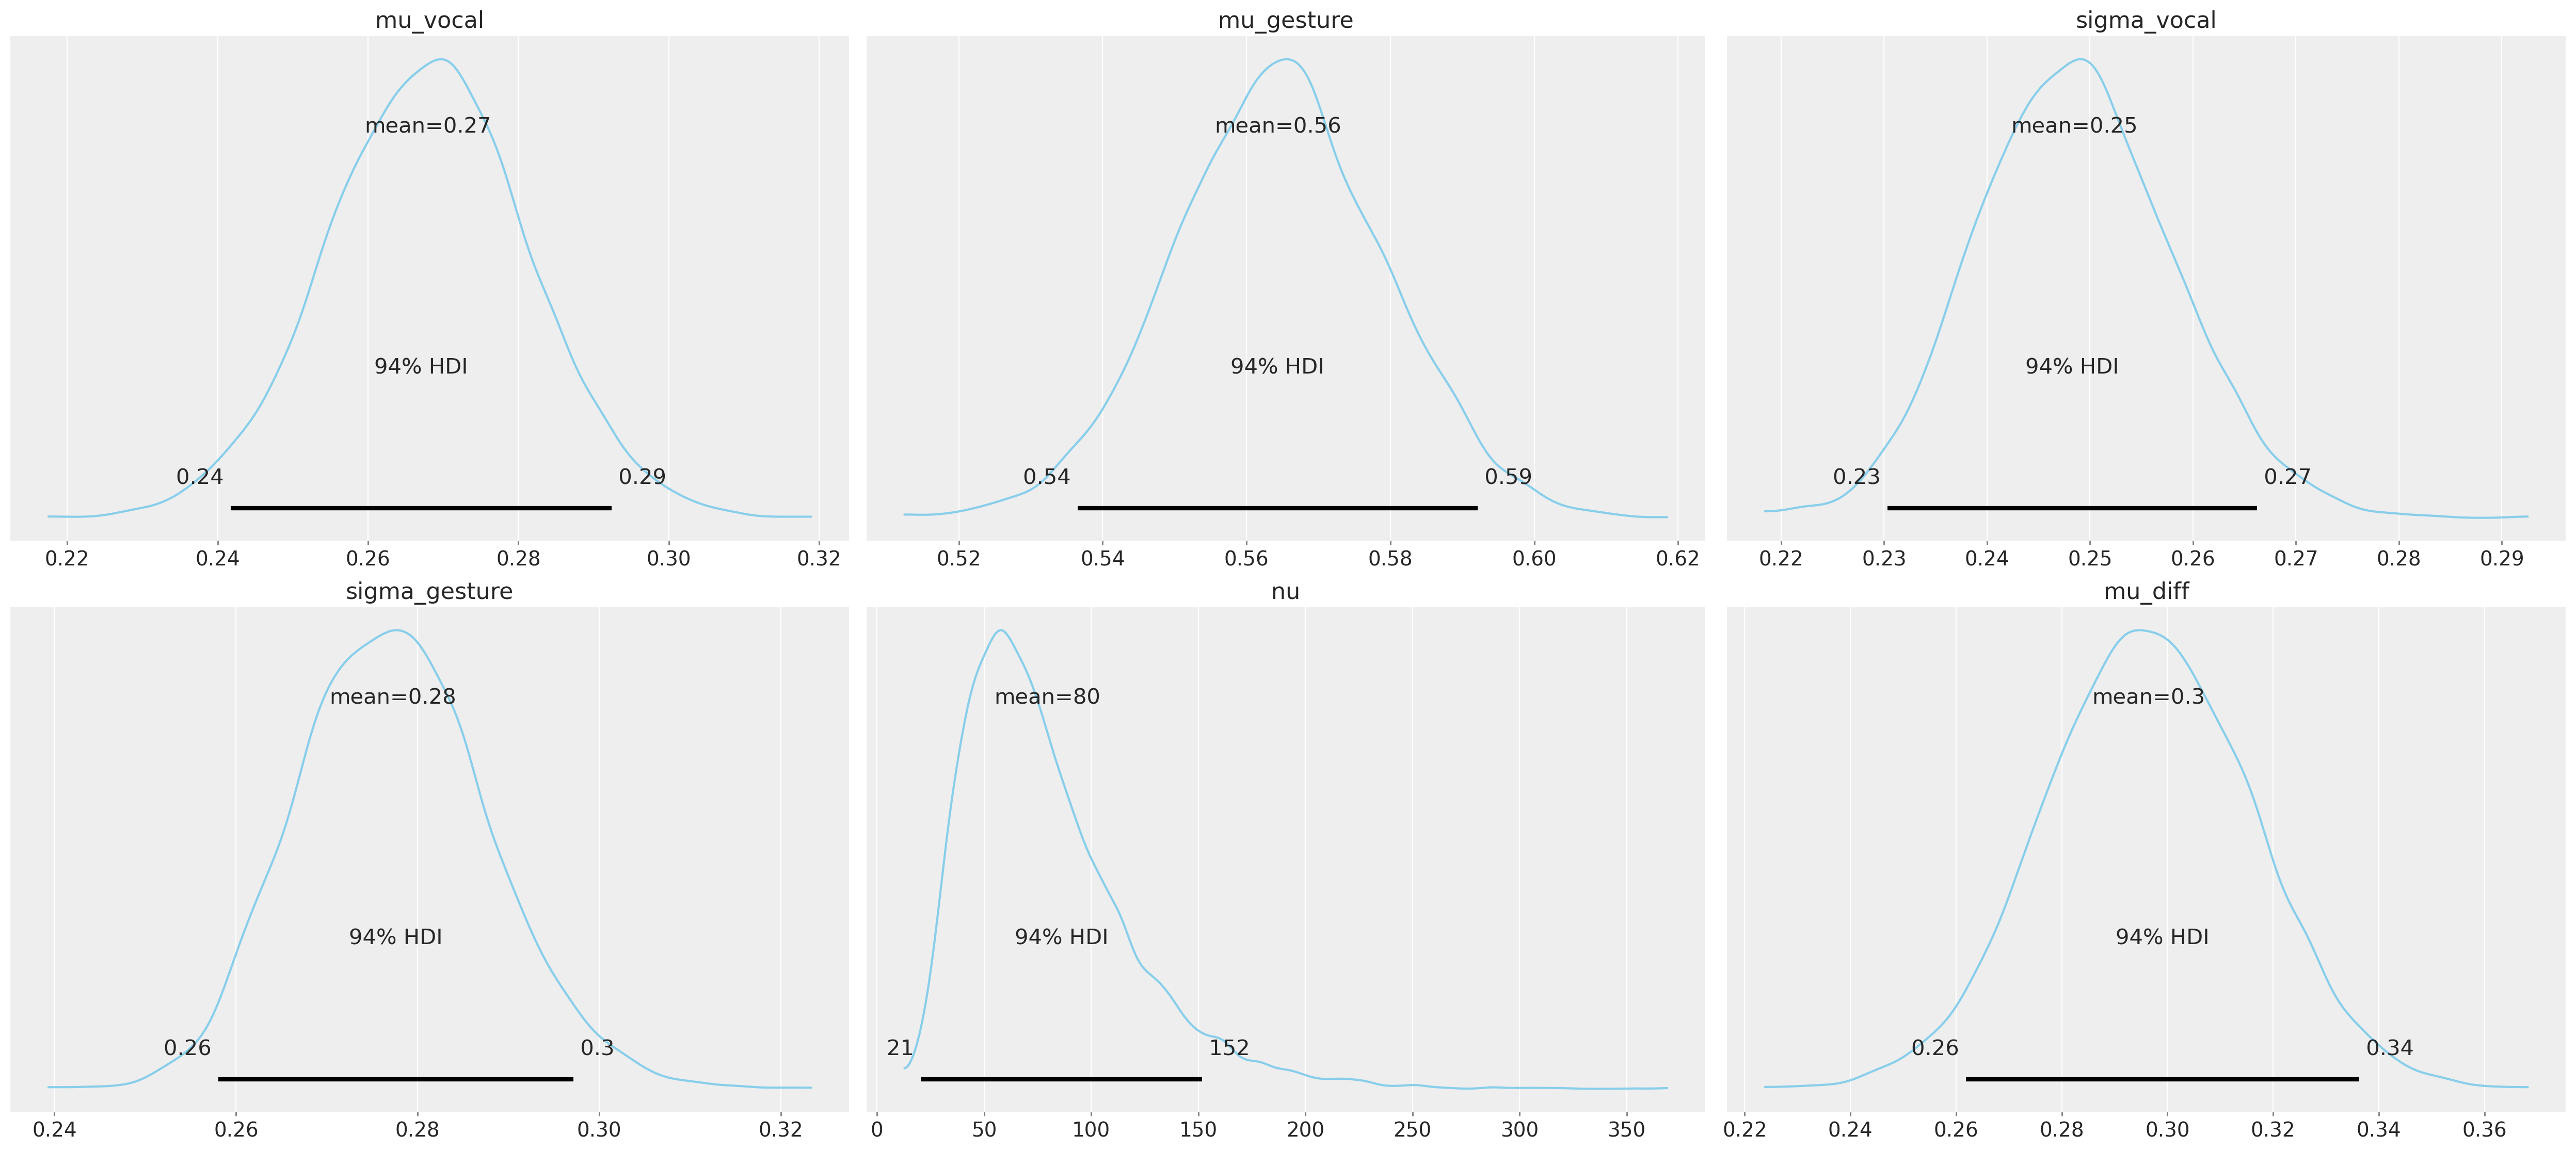

In [68]:
az.plot_posterior(
    trace,
    var_names=["mu_vocal", "mu_gesture", "sigma_vocal", "sigma_gesture", "nu", "mu_diff"],
    color="#87ceeb",
);

In [69]:
az.summary(trace, var_names=["mu_vocal", "mu_gesture", "mu_diff"])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_vocal,0.268,0.013,0.242,0.292,0.0,0.0,10371.0,6745.0,1.0
mu_gesture,0.564,0.015,0.537,0.592,0.0,0.0,12119.0,6290.0,1.0
mu_diff,0.296,0.020,0.262,0.336,0.0,0.0,11487.0,6682.0,1.0


In [72]:
az.summary(trace, var_names=["mu_diff"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_diff,0.296,0.02,0.262,0.336,0.0,0.0,11487.0,6682.0,1.0


# Bayes factor

In [70]:
from scipy.stats import gaussian_kde

# Extract posterior samples of mu_diff
posterior_samples = trace.posterior['mu_diff'].values.flatten()

# Approximate prior: Normal(0, 10), or whatever you used
prior_samples = np.random.normal(loc=0, scale=10, size=10000)

# KDEs for prior and posterior
posterior_kde = gaussian_kde(posterior_samples)
prior_kde = gaussian_kde(prior_samples)

# Savage-Dickey ratio: density at 0
BF_10 = prior_kde(0) / posterior_kde(0)
print(f"Bayes Factor BF₁₀ (difference ≠ 0 vs = 0): {BF_10}")

Bayes Factor BF₁₀ (difference ≠ 0 vs = 0): [inf]


C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\1015133839.py:14: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)


Let's build a function that incorporates this for each npy array

In [75]:
def calculate_diff_bayes_factor(sim_array):

    sim_stats = pd.DataFrame()
    
    for i in range(len(sample)):
        # This is the simulated expressibility
        express_array = np.array(sim_array[i])
        vocal = np.sum(express_array[:, 1])
        gesture = np.sum(express_array[:, 2])
        
        # Combine data
        data = np.concatenate([vocal, gesture])
        group = np.array([0] * len(vocal) + [1] * len(gesture))  # 0 = vocal, 1 = gesture

        with pm.Model() as best_model:
            mu_vocal = pm.Normal("mu_vocal", mu=0, sigma=10)
            mu_gesture = pm.Normal("mu_gesture", mu=0, sigma=10)

            sigma_vocal = pm.HalfNormal("sigma_vocal", sigma=10)
            sigma_gesture = pm.HalfNormal("sigma_gesture", sigma=10)

            nu = pm.Exponential("nu", 1/30)

            mu = pm.math.switch(group, mu_gesture, mu_vocal)
            sigma = pm.math.switch(group, sigma_gesture, sigma_vocal)

            obs = pm.StudentT("obs", nu=nu, mu=mu, sigma=sigma, observed=data)

            # Derived variable: difference in means
            mu_diff = pm.Deterministic("mu_diff", mu_gesture - mu_vocal)

            trace = pm.sample(2000, tune=1000, return_inferencedata=True)

            results = az.summary(trace, var_names=["mu_diff"])

            # Bayes Factor as the Savage-Dickey ratio

            posterior_samples = trace.posterior['mu_diff'].values.flatten()
            prior_samples = np.random.normal(loc=0, scale=10, size=10000)

            posterior_kde = gaussian_kde(posterior_samples)
            prior_kde = gaussian_kde(prior_samples)

            BF_10 = prior_kde(0) / posterior_kde(0)

            # Add BF to results
            results['BF_10'] = BF_10
            sim_stats = pd.concat([sim_stats, results], axis=0)

    return sim_stats.reset_index(drop=True)


        

In [76]:
sample_test = calculate_diff_bayes_factor(sample)
sample_test

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 11 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 11 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 11 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 11 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: overflow encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: overflow encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: overflow encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 11 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 11 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 11 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 11 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 11 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 11 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 11 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: overflow encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: overflow encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: overflow encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 16 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: overflow encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
C:\Users\kadava\AppData\Local\Temp\ipykernel_3444\438069331.py:44: RuntimeWarning: divide by zero encountered in divide
  BF_10 = prior_kde(0) / posterior_kde(0)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 16 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_vocal, mu_gesture, sigma_vocal, sigma_gesture, nu]


c:\Users\kadava\AppData\Local\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
Initializing NUTS using jitter+adapt_diag...


KeyboardInterrupt: 